In [1]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

env = gym.make('Taxi-v3').unwrapped

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


# 缓存池
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))
        return Transition(*args)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

- 添加记忆, 先使用Q表训练模型

In [4]:
memory = ReplayMemory(50000)

In [5]:
import random
from IPython.display import clear_output
from time import sleep
import pandas as pd
import numpy as np

q_table = pd.read_csv("Q_table.csv").values

episodes = 10001
for _ in range(episodes):
    state = env.reset()
    epochs, penalties, reward = 0, 0, 0

    done = False

    while not done:
        action = np.argmax(q_table[state])
        next_state, reward, done, info = env.step(action)
        memory.push(state, action, next_state, reward)
        state = next_state
        if reward == -10:
            penalties += 1
        # clear_output(wait=True)
        # print(env.render(mode='ansi'))
        epochs += 1
    clear_output(wait=True)
    print(_)

10000


In [7]:
class DQN(nn.Module):

    def __init__(self, outputs, input_features=1):
        super(DQN, self).__init__()
        self.n1 = nn.Linear(input_features, 64)
        self.n2 = nn.Linear(64, 32)
        self.n3 = nn.Linear(32, outputs)

    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.n1(x))
        x = F.relu(self.n2(x))
        return self.n3(x)

In [8]:
state = env.reset()

In [9]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS = 0.6
TARGET_UPDATE = 5
ALPHA = 0.1
policy_net = DQN(env.action_space.n).to(device)
target_net = DQN(env.action_space.n).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

DQN(
  (n1): Linear(in_features=1, out_features=64, bias=True)
  (n2): Linear(in_features=64, out_features=32, bias=True)
  (n3): Linear(in_features=32, out_features=6, bias=True)
)

In [10]:
def select_action(state):
    sample = random.random()
    if sample < EPS:
        with torch.no_grad():
            return int(torch.max(policy_net(torch.Tensor([[state]])), 1)[1])
    else:
        return int(torch.tensor([[random.randrange(env.action_space.n)]], device=device, dtype=torch.long))

In [12]:
optimizer = optim.RMSprop(policy_net.parameters(), lr=ALPHA)
LOSS_FUNC = nn.HuberLoss()

In [13]:
from IPython.display import clear_output
from time import sleep

In [14]:
def new_optimizer():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    reward_batch = torch.tensor([batch.reward], device=device, dtype=torch.float32).view(-1, 1)
    state_batch = torch.tensor([batch.state], device=device, dtype=torch.float32).view(-1, 1)
    next_state_batch = torch.tensor([batch.next_state], device=device, dtype=torch.float32).view(-1, 1)
    action_batch = torch.tensor([batch.action], device=device, dtype=torch.int64).view(-1, 1)

    Q_val_next = target_net(next_state_batch).detach().max(1)[0]
    Q_val_policy = policy_net(state_batch).max(1)[0]
    Q_val_target = reward_batch.squeeze() + GAMMA * Q_val_next
    loss = LOSS_FUNC(Q_val_target, Q_val_policy)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


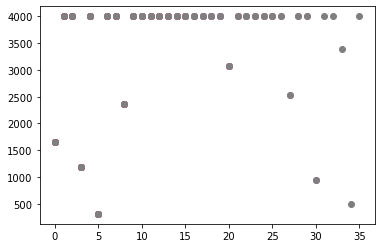

更新!循环次数:35
当前轮次36



KeyboardInterrupt



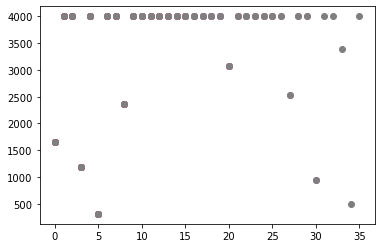

In [15]:
# policy_net进行预测
num_episodes = 500
record = {}
for i in range(num_episodes):
    state = env.reset()
    step = 0
    print(f"当前轮次{i}")
    for t in count():
        action = select_action(state)
        next_observation, reward, done, info = env.step(action)
        memory.push(state, action, next_observation, reward)
        state = next_observation
        new_optimizer()
        # clear_output(wait=True)
        # env.render()
        step += 1
        if step > 4000:
            record[i] = step
            break
        if done:
            record[i] = step
            break

    if i % TARGET_UPDATE == 0:
        clear_output(wait=True)
        plt.scatter(record.keys(), record.values())
        display.display(plt.gcf())
        target_net.load_state_dict(policy_net.state_dict())
        print(f"更新!循环次数:{i}")

In [16]:
# show
num_episodes = 500
record = {}
for i in range(num_episodes):
    state = env.reset()
    step = 0
    print(f"当前轮次{i}")
    for t in count():
        action = select_action(state)
        next_observation, reward, done, info = env.step(action)
        # memory.push(state, action, next_observation, reward)
        state = next_observation
        new_optimizer()
        clear_output(wait=True)
        env.render()
        step += 1
        if step > 4000:
            record[i] = step
            break
        if done:
            record[i] = step
            break

    if i % TARGET_UPDATE == 0:
        # clear_output(wait=True)
        # plt.scatter(record.keys(), record.values())
        # display.display(plt.gcf())
        target_net.load_state_dict(policy_net.state_dict())
        print(f"更新!循环次数:{i}")

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)



KeyboardInterrupt

